In [1]:
import pandas as pd 
import yaml
import torch
import os
from transformers import (AutoTokenizer, AutoModelForCausalLM)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import warnings
import itertools
from evaluation_tools import compute_metrics_crossval
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


/Users/timour/repositories/llm-liedetector-keyphrase/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First some parameters and functions that remain constant for the rest of the notebook:

In [2]:
ds_names=["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors",
"neg_inventors", "animal_class", "neg_animal_class", "element_symb", "neg_element_symb"]
LAYERS=[12,14,16,18,20]

#### CHOOSE FROM THE 2 LLMS
model_options=["Llama3-8b-instruct", "Mistral-8b-instruct"]
model_name="Mistral-8b-instruct"

#### CHOOSE FROM THE PROBES 
#(note that one should not rely on the TTPD figures for anything besides the original training set because we have not explored how polarities would work in the conversational formats)
probe_options=["LRC","LR","PCA","TTPD"]
probe_name="PCA"

### NUMBER OF ITERATIONS TO AVERAGE OUT REBALANCING RANDOMNESS 
N=10

### CREATE SUBDIR WHERE FIGS AND CSVs WILL BE SAVED
save_dir=f"figures/{model_name}/{probe_name}"
os.makedirs(save_dir, exist_ok=True)

def root_paths(keyphrase,layer):

    root_path_format_1=f"data/acts/{model_name}/layer_{layer}/format1_{keyphrase}"
    root_path_format_2=f"data/acts/{model_name}/layer_{layer}/format2_{keyphrase}"
    root_path_format_3=f"data/acts/{model_name}/layer_{layer}/format3_{keyphrase}"

    original=f"data/acts/{model_name}/layer_{layer}/original"

    formats=[ root_path_format_1, root_path_format_2,root_path_format_3]

    return original, formats


def return_generalization_matrix(train_formats, test_formats, N, probe_type):

    print(f"computing generalization matrix for {probe_type} probe")

    generalization_matrices= np.zeros(shape=(len(train_formats),len(test_formats)))

    for i, format_row  in enumerate(train_formats):
        for j,format_columns in enumerate(test_formats):
            
            accuracies_dict, average_accuracy_dict=compute_metrics_crossval(root_path_train=format_row,root_path_test=format_columns,  topic_names=ds_names, probes=[probe_type], N=N)
                                                                                    
            generalization_matrices[i,j]=average_accuracy_dict[probe_type]
    
    return generalization_matrices

### Figure 1: How well does the truth direction generalize from statements to prompts?

In [3]:
layer_matrix=np.zeros(shape=(7,len(LAYERS)))

for i, layer in enumerate(LAYERS):
    
    original, test_formats_standard=root_paths("none", layer)
    _, test_formats_longer=root_paths("longer", layer)

    train_formats=[original]
    test_formats=[original]+test_formats_standard+test_formats_longer
    generalization_matrices=return_generalization_matrix(train_formats, test_formats, N, probe_name)
    layer_matrix[:,i]=generalization_matrices

computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe


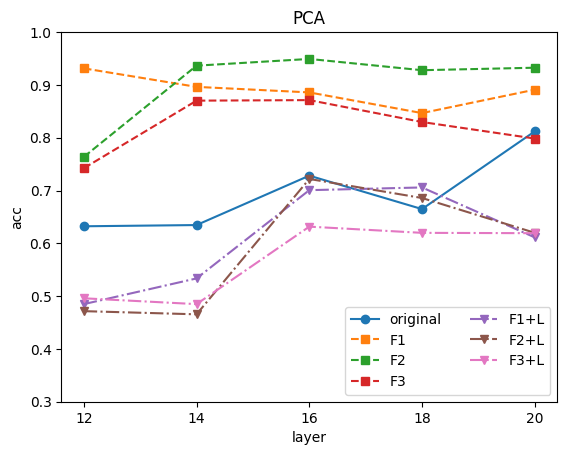

In [4]:
labels=["original","F1","F2","F3","F1+L","F2+L","F3+L"]
shapes=["o"]+["s"]*3+["v"]*3
linestyles=["-"]+["--"]*3+["-."]*3
plt.figure(i)

for i, label in enumerate(labels):
    plt.plot(LAYERS, layer_matrix[i,:], linestyle=linestyles[i], marker= shapes[i], label=labels[i]  )

plt.ylim([0.3,1])
plt.legend(loc="lower right",ncol=2)
plt.xlabel("layer")
plt.ylabel("acc")
plt.xticks(LAYERS)
plt.title(probe_name)


plt.savefig(f"{save_dir}/original_generalization", dpi=300)
df = pd.DataFrame(layer_matrix, index=labels, columns=LAYERS).transpose()
df.index.name = 'layer'
df.to_csv(f"{save_dir}/original_generalization.csv")

### Figure 2: How does the truth direction generalize from format 1? 

In [5]:
LAYERS=[12,14,16,18,20]

layer_matrix=np.zeros(shape=(6,len(LAYERS)))

for i, layer in enumerate(LAYERS):
    original, standard_formats=root_paths("none", layer)
    _, longer_formats=root_paths("longer", layer)
    train_formats=standard_formats[0:1]
    test_formats=standard_formats+longer_formats
    generalization_matrices=return_generalization_matrix(train_formats, test_formats, N, probe_name)
    layer_matrix[:,i]=generalization_matrices

computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe


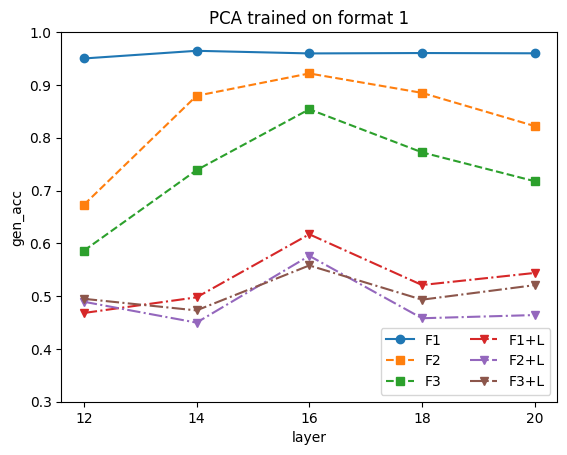

In [6]:
labels=["F1","F2","F3","F1+L","F2+L","F3+L"]
shapes=["o"]+["s"]*2+["v"]*3
linestyles=["-"]+["--"]*2+["-."]*3


plt.figure(i)

for i, label in enumerate(labels):
    plt.plot(LAYERS, layer_matrix[i,:], linestyle=linestyles[i], marker= shapes[i], label=labels[i]  )

plt.ylim([0.3,1])
plt.legend(loc="lower right",ncol=2)
plt.xlabel("layer")
plt.ylabel("gen_acc")
plt.xticks(LAYERS)
plt.title(f"{probe_name} trained on format 1")

plt.savefig(f"{save_dir}/format1_generalization", dpi=300)
df = pd.DataFrame(layer_matrix, index=labels, columns=LAYERS).transpose()
df.index.name = 'layer'
df.to_csv(f"{save_dir}/format1_generalization.csv")

### Figure 3: Heatmap for all F -> F+L cross-accuracies fixed layer

In [7]:
LAYER=18

original, formats1=root_paths("none", LAYER)
_, formats2=root_paths("longer", LAYER)

formats_train=formats1
formats_test=formats1+formats2 
generalization_matrices=return_generalization_matrix(formats_train, formats_test, N, probe_name)

computing generalization matrix for PCA probe


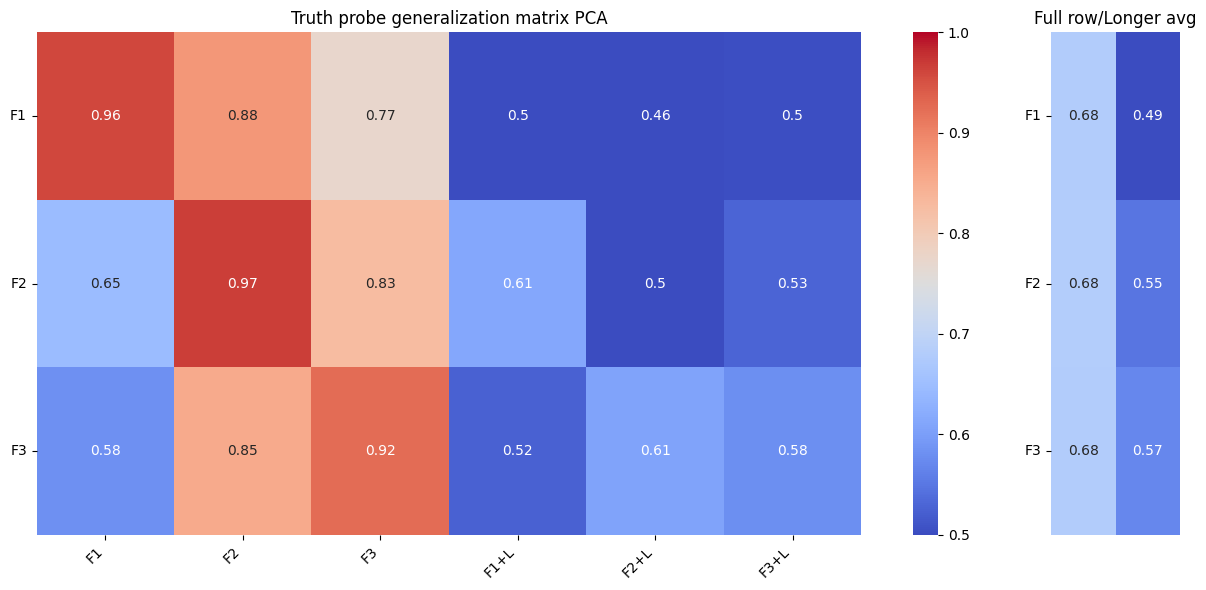

In [8]:

row_labels = [f"F{i}" for i in range(1,4)]
col_labels = (
    [f"F{i}" for i in range(1,4)]
    + [f"F{i}+L" for i in range(1,4)]
)
 
df = pd.DataFrame(generalization_matrices, index=row_labels, columns=col_labels)

longer_cols   = [f"F{i}+L" for i in range(1, 4)]
longer_avg    = df[longer_cols].mean(axis=1)              
overall_avg   = df.mean(axis=1)                         

row_averages = pd.DataFrame(
    {"Row Avg": overall_avg,"Longer Avg": longer_avg},
    index=df.index
)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[4, 0.5])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)   

sns.heatmap(
    df,
    annot=True,
    cmap="coolwarm",
    xticklabels=df.columns,
    yticklabels=df.index,
    ax=ax0,
    vmin=0.5,
    vmax=1
)
ax0.set_title(f"Truth probe generalization matrix {probe_name}")
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha="right")
ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0)

sns.heatmap(
    row_averages,
    annot=True,
    cmap="coolwarm",
    cbar=False,             
    yticklabels=df.index,
    ax=ax1,
    vmin=0.5,
    vmax=1
)
ax1.set_xticks([])          
ax1.set_title("Full row/Longer avg")    
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

plt.tight_layout()

plt.savefig(f"{save_dir}/layer-18-heatmap-standard", dpi=300)
df_rounded = df.round(2)
df_rounded.to_csv(f"{save_dir}/layer-18-heatmap-standard.csv", sep=' ', header=False, index=False, float_format='%.2f')
plt.show()

### Figure 4: Introducing Keyphrase. Let's compare F->F+L to F+K -> F+L+K

In [9]:
LAYERS=[12,14,16,18,20]

generalization_matrix_standard=np.zeros(shape=(3,len(LAYERS)))
generalization_matrix_keyphrase=np.zeros(shape=(3,len(LAYERS)))


for i, layer in enumerate(LAYERS):


    _, none=root_paths("none", layer)
    _, longer=root_paths("longer", layer)
    _, keyphrase=root_paths("keyphrase", layer)
    _, longer_keyphrase=root_paths("longer_keyphrase", layer)

    for j in range(0,3):

        formats_standard=none[j:j+1]
        formats_keyphrase=keyphrase[j:j+1]

        formats_longer=longer[j:j+1]
        formats_longer_keyphrase=longer_keyphrase[j:j+1]

        generalization_acc_standard=return_generalization_matrix(formats_standard, formats_longer, N, probe_name)
        generalization_acc_keyphrase=return_generalization_matrix(formats_keyphrase, formats_longer_keyphrase, N, probe_name)

        generalization_matrix_standard[j,i]=generalization_acc_standard[0,0]
        generalization_matrix_keyphrase[j,i]=generalization_acc_keyphrase[0,0]
        
generalization_matrix=np.vstack((generalization_matrix_standard, generalization_matrix_keyphrase))

computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix fo

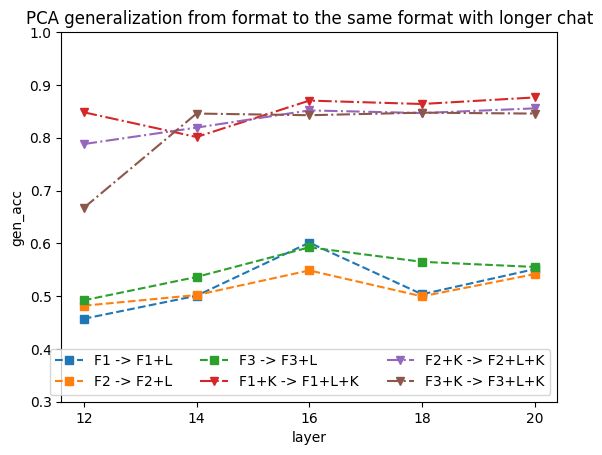

In [10]:
labels1=["F1 -> F1+L" , "F2 -> F2+L" , "F3 -> F3+L"]
labels2=["F1+K -> F1+L+K", "F2+K -> F2+L+K" ,"F3+K -> F3+L+K" ]
labels=labels1+labels2
shapes=["s"]*3+["v"]*3
linestyles=["--"]*3+["-."]*3


plt.figure(i)

for i, label in enumerate(labels):
    plt.plot(LAYERS, generalization_matrix[i,:], linestyle=linestyles[i], marker= shapes[i], label=labels[i]  )

 
plt.ylim([0.3,1])
plt.legend(loc="lower right",ncol=3)
plt.xlabel("layer")
plt.ylabel("gen_acc")
plt.xticks(LAYERS)
plt.title(f"{probe_name} generalization from format to the same format with longer chat")

plt.savefig(f"{save_dir}/short-long-generalization", dpi=300)
df = pd.DataFrame(generalization_matrix, index=labels, columns=LAYERS).transpose()
df.index.name = 'layer'
df.to_csv(f"{save_dir}/short-long-generalization.csv")

### Figure 5: Heatmap for F+K -> F+K+L

In [12]:
LAYER=18

original, formats1=root_paths("keyphrase", LAYER)
_, formats2=root_paths("longer_keyphrase", LAYER)


formats_train=formats1
formats_test=formats1+formats2

generalization_matrices=return_generalization_matrix(formats_train, formats_test, N, probe_name)


computing generalization matrix for PCA probe


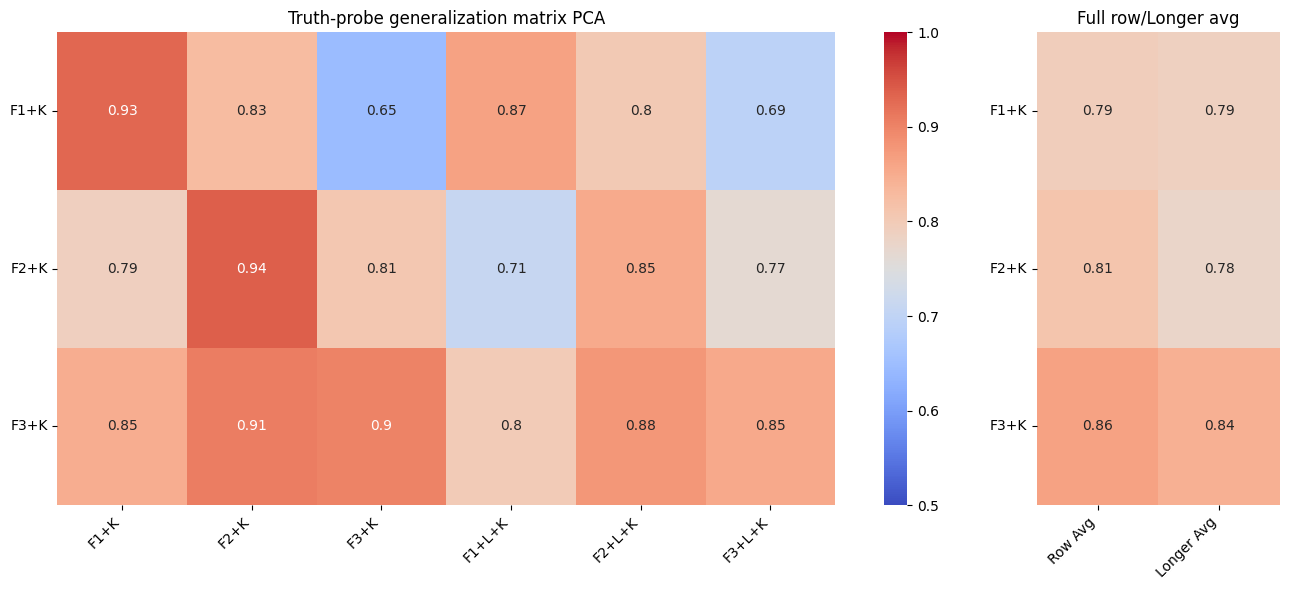

In [13]:
row_labels = [f"F{i}+K" for i in range(1,4)]
col_labels = (
    [f"F{i}+K" for i in range(1,4)]
    + [f"F{i}+L+K" for i in range(1,4)]
)
 
df = pd.DataFrame(generalization_matrices, index=row_labels, columns=col_labels)

longer_cols   = [f"F{i}+L+K" for i in range(1, 4)]
longer_avg    = df[longer_cols].mean(axis=1)              # ←  ⟵ “Longer Avg”
overall_avg   = df.mean(axis=1)                           # ←  ⟵ “Row Avg”

row_averages = pd.DataFrame(
    {"Row Avg": overall_avg,"Longer Avg": longer_avg},
    index=df.index
)

fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[4, 1])  # a bit wider

# Main heatmap
ax0 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    df, annot=True, cmap="coolwarm",
    xticklabels=df.columns, yticklabels=df.index,
    ax=ax0, vmin=0.5, vmax=1
)
ax0.set_title(f"Truth‑probe generalization matrix {probe_name}")
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha="right")
ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0)

# Two‑column heatmap for the averages
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
sns.heatmap(
    row_averages,
    annot=True, cmap="coolwarm", cbar=False,
    yticklabels=df.index, ax=ax1, vmin=0.5, vmax=1
)
ax1.set_title("Full row/Longer avg")   # label above the averages
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

plt.tight_layout()

plt.savefig(f"{save_dir}/layer18-generalization-keyphrase", dpi=300)
df_rounded = df.round(2)
df_rounded.to_csv(f"{save_dir}/layer18-generalization-keyphrase.csv", sep=' ', header=False, index=False, float_format='%.2f')
plt.show()



### Figure 6: Control phrase?

In [14]:
LAYERS=[12,14,16,18,20]

generalization_matrix_keyphrase=np.zeros(shape=(3,len(LAYERS)))
generalization_matrix_control=np.zeros(shape=(3,len(LAYERS)))


for i, layer in enumerate(LAYERS):


    _, keyphrase=root_paths("keyphrase", layer)
    _, longer_keyphrase=root_paths("longer_keyphrase", layer)
    _, control=root_paths("control", layer)
    _, longer_control=root_paths("longer_control", layer)

    for j in range(0,3):

        formats_keyphrase=keyphrase[j:j+1]
        formats_control=control[j:j+1]

        formats_longer_keyphrase=longer_keyphrase[j:j+1]
        formats_longer_control=longer_control[j:j+1]

        generalization_acc_keyphrase=return_generalization_matrix(formats_keyphrase, formats_longer_keyphrase, N, probe_name)
        generalization_acc_control=return_generalization_matrix(formats_control, formats_longer_control, N, probe_name)

        generalization_matrix_keyphrase[j,i]=generalization_acc_keyphrase[0,0]
        generalization_matrix_control[j,i]=generalization_acc_control[0,0]
        
generalization_matrix=np.vstack((generalization_matrix_keyphrase, generalization_matrix_control))

computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix for PCA probe
computing generalization matrix fo

In [15]:
### the rows in generalization matrix are now

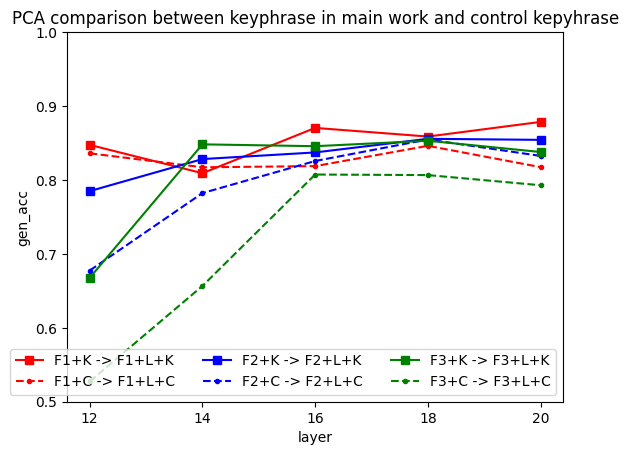

In [16]:
labels1=["F1+K -> F1+L+K", "F2+K -> F2+L+K" ,"F3+K -> F3+L+K" ]
labels2=["F1+C -> F1+L+C", "F2+C -> F2+L+C" ,"F3+C -> F3+L+C" ]

colors=["red","blue","green"]

shapes1=["s"]*3 
shapes2=["."]*3

linestyles1=["-"]*3 
linestyles2=["--"]*3 

plt.figure(i)

for i, label in enumerate(labels1):
    plt.plot(LAYERS, generalization_matrix[i,:], linestyle=linestyles1[i], marker= shapes1[i], label=labels1[i], color=colors[i] )
    plt.plot(LAYERS, generalization_matrix[i+3,:], linestyle=linestyles2[i], marker= shapes2[i], label=labels2[i], color=colors[i] )

plt.ylim([0.5,1])
plt.legend(loc="lower right",ncol=3)
plt.xlabel("layer")
plt.ylabel("gen_acc")
plt.xticks(LAYERS)
plt.title(f"{probe_name} comparison between keyphrase in main work and control kepyhrase")

plt.savefig(f"{save_dir}/control_comparison", dpi=300)
df = pd.DataFrame(generalization_matrix, index=labels, columns=LAYERS).transpose()
df.index.name = 'layer'
df.to_csv(f"{save_dir}/control_comparison.csv")

In [17]:
3

3